In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from datasets.unet_dataset import UNetDataset
from models.unext import UNext

from scripts.train import train
from scripts.validate import validate

from utils.image import torch_to_numpy

c:\Users\ubar\Envs\mva_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ubar\Envs\mva_env\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


First, let's load the datasets :

In [2]:
# data paths for train and validation
val_dir = "challenge_data/validation/validation"
train_dir = "challenge_data/train/train"

# data augmentation
val_transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(size=(110,80))])
train_transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(size=(110,80)),
                        transforms.RandomAffine(degrees=(0, 0), translate=(0., 0.), scale=(0.8, 1.2))])

# train and validation datasets
val_dataset = UNetDataset(val_dir, transforms=val_transform)
train_dataset = UNetDataset(train_dir, transforms=train_transform)

Some plots of the dataset : 

- Inputs : 

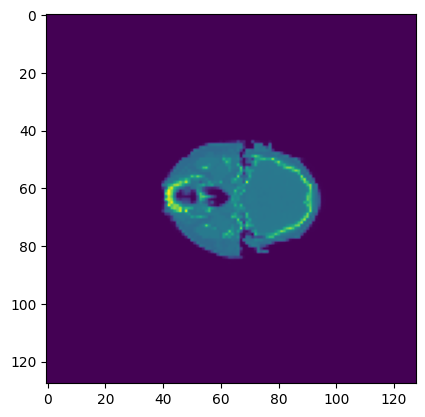

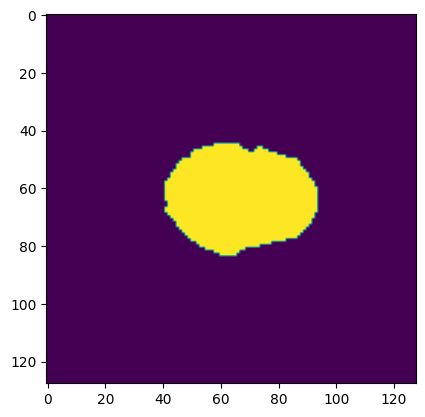

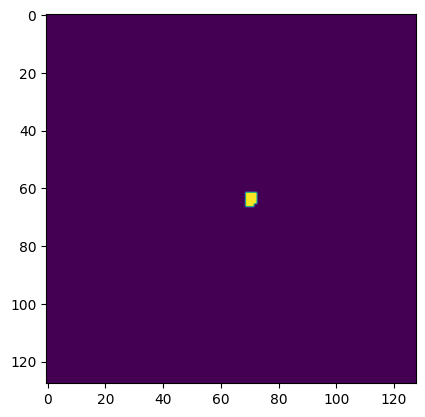

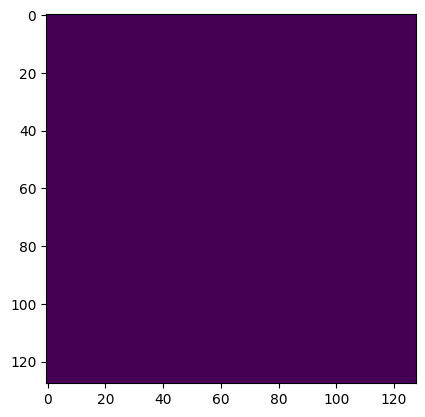

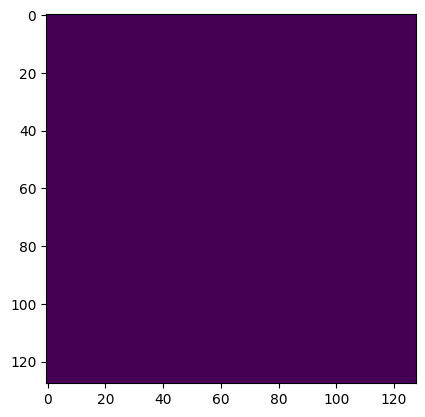

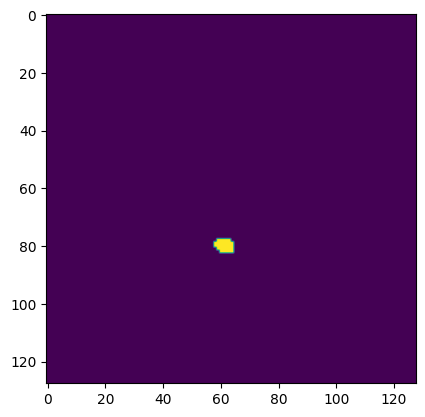

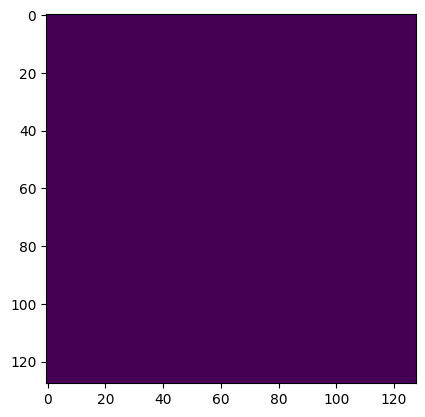

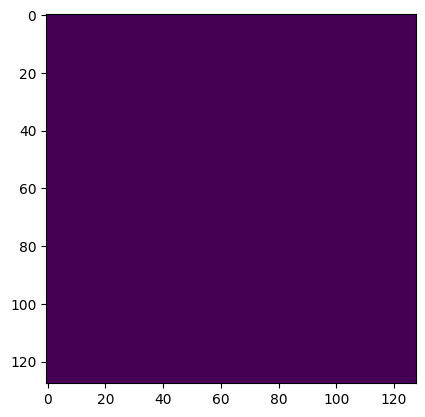

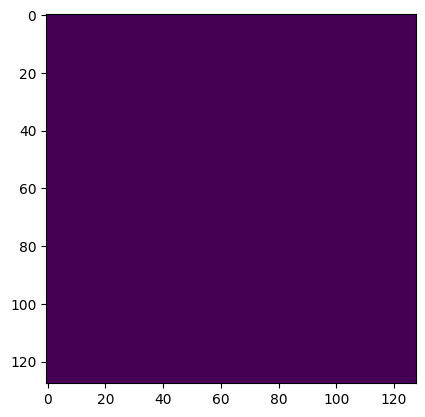

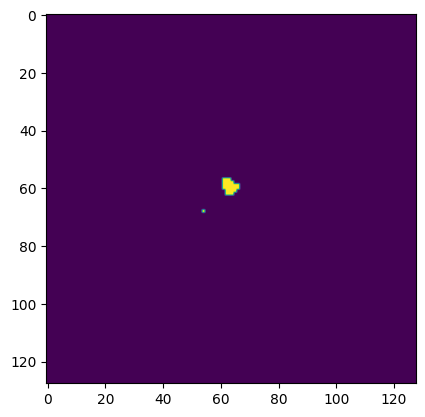

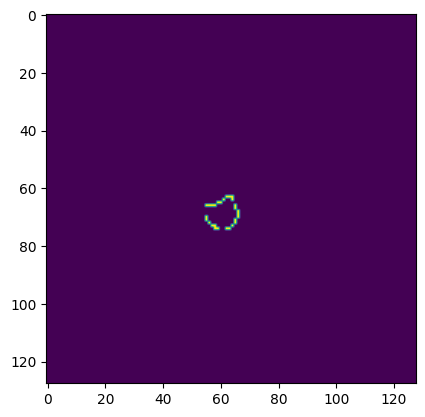

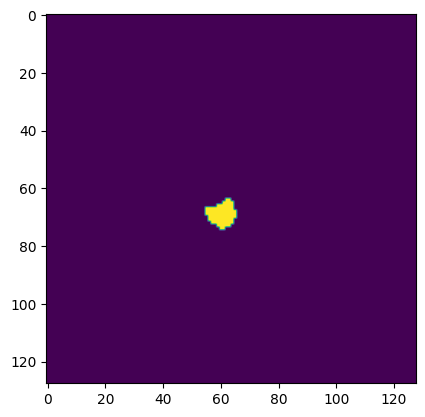

In [3]:
# pick an element of the dataset
elem = next(iter(train_dataset))
    
# show CT scans, possible dose mask and 10 organ masks
for el in elem['input'][0]:
    m = nn.ZeroPad2d((24,24, 9, 9))
    plt.figure()
    plt.imshow(torch_to_numpy(m(el.unsqueeze(0).unsqueeze(0)).detach().cpu()[0]))
    plt.show()

Labels : 

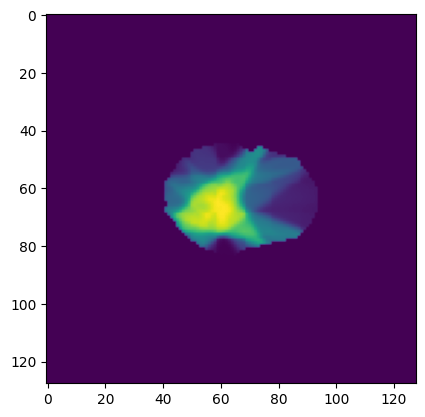

In [4]:
# pick label corresponding to the inputs above
label=elem["label"]
plt.figure()
plt.imshow(torch_to_numpy(m(label).detach().cpu()))
plt.show()

Let's build our model : 

In [5]:
# the model takes an input with 12 channels : CT scan, possible dose mask, 10 organ masks
model = UNext(n_channels=12)
print(model)

UNext(
  (encoder1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ebn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ebn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ebn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
  (norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dnorm3): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
  (dnorm4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (block1): ModuleList(
    (0): shiftedBlock(
      (drop_path): Identity()
      (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
      (mlp): shiftmlp(
        (fc1): Linear(in_features=160, out_feature

Train the model : 

In [6]:
train(model.cuda(), train_dataset, val_dataset, batch_size=32)

RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 3

Load our best model : 

In [32]:
model = UNext(n_channels=12).cuda().eval()
#path leading to the model
PATH = "models_ckpt/modelunet034.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Validate the model : 

In [45]:
validate(model.cuda(), val_dataset)

100%|██████████| 75/75 [01:33<00:00,  1.24s/it]

val loss :  0.38624177072464283


0.38624177072464283

Sample example : 

In [34]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
# pick one example of the validation set
val_sample = next(iter(val_loader))
val_elem = [val_sample["input"][0].cuda(), val_sample["input"][1].cuda()]
m = nn.ZeroPad2d((24,24, 9, 9))
out = m(model(val_elem))
out = torch.multiply(out, val_sample["possible_dose_mask"].cuda().unsqueeze(1))

Left : Prediction

Right : Groundtruth

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


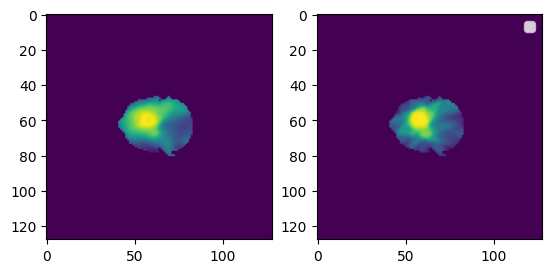

In [44]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(torch_to_numpy(out[0].cpu()))
plt.subplot(1,2,2)
plt.imshow(torch_to_numpy(m(val_sample["label"])[0].cpu()))
plt.legend()
plt.show()